### Laboration deep learning AI21
---
Syftet med den här labben är att använda deep learning för computer vision för att lära sig att klassificera
olika objekt.
I den här labben kommer du få jobba med bildbehandling, filhantering, bygga upp egna tränings, validerings
och testdataset från en mängd av bilder. Vidare får du jobba med begränsade datamängder för att efterlikna
verkligheten när dataanskaffning är en oerhört dyr process. Efter databehandlingen och databearbetningen
kommer du få pröva olika slags convolutional neural networks tränade från scratch och slutligen använda
dig av transfer learning för att återanvända nätverk skapade av toppforskare inom computer vision.

---
0. EDA och filhantering (*)

a) Börja med att ladda ned datasetet Dogs vs Cats från Kaggle. Extrahera den och lägg den i din labfolder,
glöm inte att lägga till den till .gitignore.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import cv2
import random
import os
import shutil


plt.style.use("seaborn-white")

In [2]:
#train_path = "original_data/train/train/"
train_path="/kaggle/input/dogs-vs-cats/train/train/"
#test_path="/kaggle/input/dogs-vs-cats/test/test"

files_train_path = os.listdir(train_path)

images_names = pd.DataFrame({"file_name" : files_train_path})
print(f"total number of images: {len(images_names)}")
images_names.head(10)

df_cat = images_names[images_names["file_name"].str.contains("cat")==True]
df_dog = images_names[images_names["file_name"].str.contains("dog")==True]

print(f"number of cats: {len(df_cat)}, number of dogs: {len(df_dog)}")

total number of images: 25000
number of cats: 12500, number of dogs: 12500


In [3]:
df_cat

file_name
0      cat.12461.jpg
6      cat.10176.jpg
7       cat.8194.jpg
9       cat.3498.jpg
11       cat.891.jpg
...              ...
24988   cat.1516.jpg
24991  cat.12298.jpg
24992   cat.4392.jpg
24993   cat.7591.jpg
24995   cat.3664.jpg

[12500 rows x 1 columns]

In [4]:
df_dog

file_name
1       dog.3443.jpg
2       dog.7971.jpg
3      dog.10728.jpg
4       dog.1942.jpg
5        dog.375.jpg
...              ...
24994   dog.3865.jpg
24996   dog.1783.jpg
24997   dog.9392.jpg
24998   dog.1631.jpg
24999   dog.6938.jpg

[12500 rows x 1 columns]

b) Läs in 10 bilder slumpmässigt, plotta dem och extrahera deras labels och skriv ut i titeln.

In [5]:
def pick_random_imgs(data_path, n_of_images=10):

    image_names= os.listdir(data_path)
    image_names_picked = random.sample(image_names, n_of_images)
    return image_names_picked

def get_label(data_path, image_names_picked):
    labels=[]
    images=[]

    for image_name in image_names_picked:
        label = image_name.split('.')[0]
        if label == 'cat':
            labels.append(0)
        else:
            labels.append(1)
        img = plt.imread(f"{data_path}{image_name}")
        images.append(img)
    images = np.asarray(images, dtype=object)    
    labels = np.asarray(labels)
    # np.asarray to solve problem: 'list' object has no attribute 'shape'
        
    return images, labels

def plot_imgs(images, labels, ncols = 5, figsize = (20,20), n_of_images=10):
    nrows = int(n_of_images/ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize = figsize)
	
    for i, ax, label in zip(range(n_of_images), axes.flatten(), labels):
        ax.imshow(images[i])
        ax.axis("off")
        if label==0:
            ax.set(title=f'{label}:cat')
        else:
            ax.set(title=f'{label}:dog')

    fig.subplots_adjust(wspace=0.1, hspace=0.1, bottom=0.01, top=0.4)

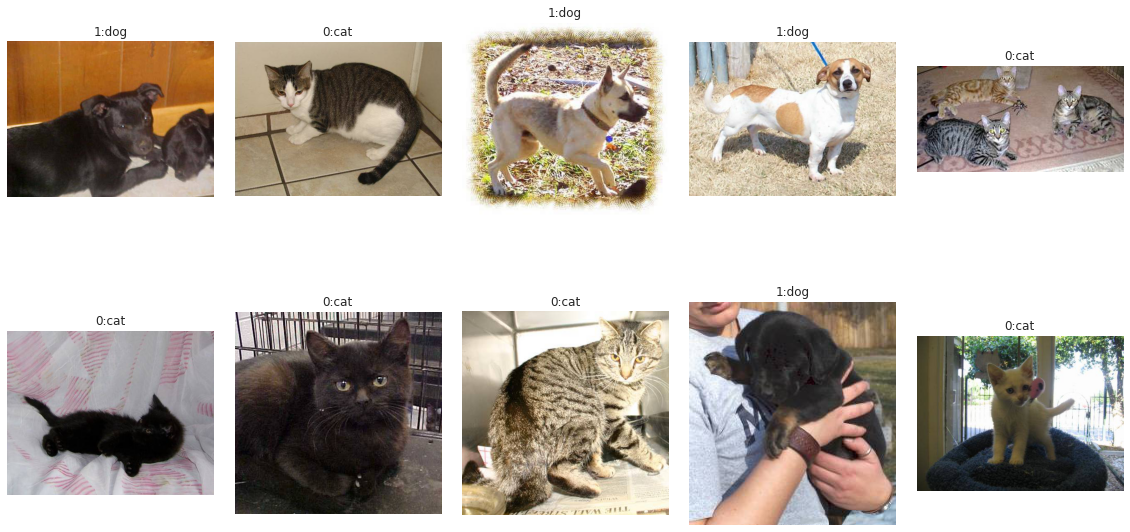

In [6]:
image_names_picked= pick_random_imgs(train_path)
images, labels = get_label(train_path, image_names_picked)
plot_imgs(images, labels)

c) Skapa folderstrukturen nedan med Python, Notera att det är okej att ha fler pythonskript, notebooks, fler experiment, eller annat relevant i labbfoldern. Glöm inte att ha gitignore på datafilerna.

In [7]:
folder_size = ['small', 'tiny']
folder_type = ['train', 'test', 'val']

for size in folder_size:
    try:
        os.mkdir(f"experiment_{size}_data")
        for type in folder_type:
            os.mkdir(f"experiment_{size}_data/{type}")
    except FileExistsError as err:
        shutil.rmtree(f"experiment_{size}_data")
        os.mkdir(f"experiment_{size}_data")
        for type in folder_type:
            os.mkdir(f"experiment_{size}_data/{type}")


d) Nu ska du göra train|val|test split med följande splits:

experiment_small
- train - 1600 (800 dogs, 800 cats)
- val - 400 (200 dogs, 200 cats)
- test - 500 (250 dogs, 250 cats)

experiment_tiny (BONUS)
- train - 160 (80 dogs, 80 cats)
- val - 40 (20 dogs, 20 cats)
- test - 50 (25 dogs, 25 cats)

In [8]:
from sklearn.model_selection import train_test_split
def split_imgs(df_names, n_train, n_val, n_test):
    df_picked = df_names.sample(n_train+n_val+n_test, random_state=42)
    X_train, X_val_test = train_test_split(df_picked, test_size=n_val+n_test, random_state=42)
    X_val, X_test = train_test_split(X_val_test, test_size=n_test, random_state=42)

    return X_train, X_val, X_test

In [9]:
def save_images(processed_images_path, data):
    for img_name in data:
        source_path = f"{train_path}{img_name}"
        target_path = f"{processed_images_path}{img_name}"
        shutil.copyfile(source_path, target_path)

In [10]:
dfs=[df_cat, df_dog]
for df in dfs:
    X_train, X_val, X_test = split_imgs(df, 800, 200, 250)
    processed_images_path = f'experiment_small_data/train/'
    save_images(processed_images_path, X_train['file_name'])
    processed_images_path =f'experiment_small_data/val/'
    save_images(processed_images_path, X_val['file_name'])
    processed_images_path =f'experiment_small_data/test/'
    save_images(processed_images_path, X_test['file_name'])

In [11]:
dfs=[df_cat, df_dog]
for df in dfs:
    X_train, X_val, X_test = split_imgs(df, 80, 20, 25)
    processed_images_path = f'experiment_tiny_data/train/'
    save_images(processed_images_path, X_train['file_name'])
    processed_images_path =f'experiment_tiny_data/val/'
    save_images(processed_images_path, X_val['file_name'])
    processed_images_path =f'experiment_tiny_data/test/'
    save_images(processed_images_path, X_test['file_name'])

In [12]:
def random_and_get_label(path):
    files = os.listdir(path)
    random.shuffle(files)
    X_train, y_train = get_label(path, files)
    return X_train, y_train

In [13]:
X_train_small, y_train_small = random_and_get_label("experiment_small_data/train/")
X_val_small, y_val_small  = random_and_get_label("experiment_small_data/val/")
X_test_small, y_test_small = random_and_get_label("experiment_small_data/test/")

X_train_tiny, y_train_tiny = random_and_get_label("experiment_tiny_data/train/")
X_val_tiny, y_val_tiny = random_and_get_label("experiment_tiny_data/val/")
X_test_tiny, y_test_tiny = random_and_get_label("experiment_tiny_data/test/")

e) Läs in dataseten från experiment_small, experiment_tiny och plocka ut labelsvektorer, som ska vara
one-hot encoded med 0 och 1.
- plotta några bilder med deras respektive labels och kontrollera att det är korrekt.


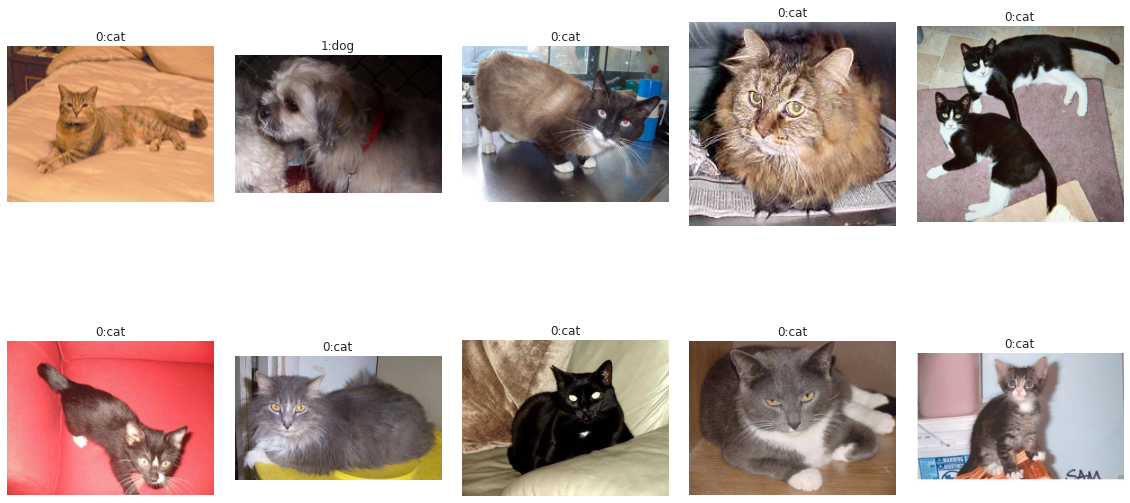

In [14]:
path = 'experiment_small_data/train/'
image_names_picked= pick_random_imgs(path)
images, labels = get_label(train_path, image_names_picked)
plot_imgs(images, labels)

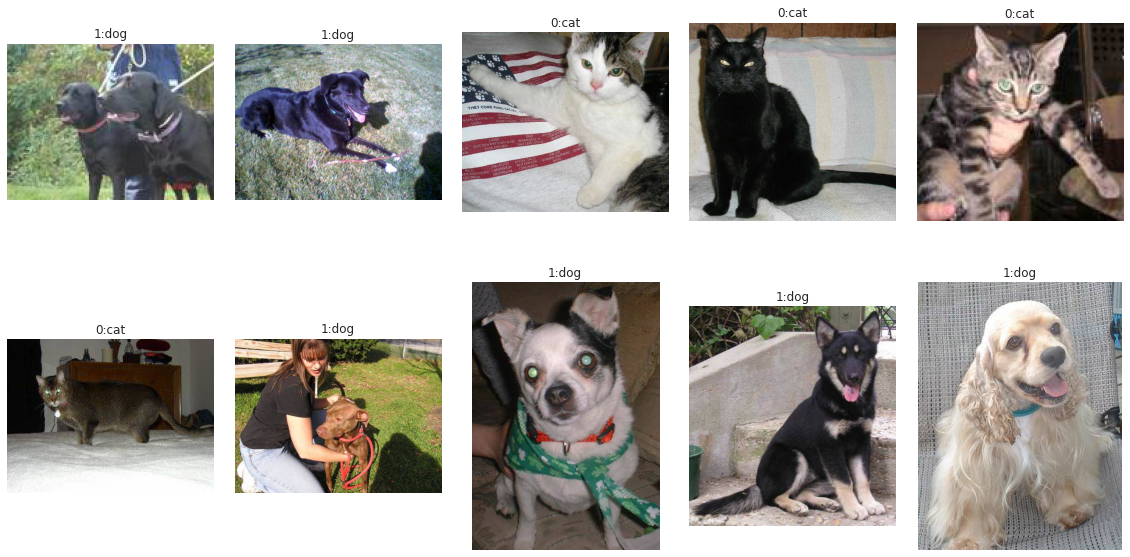

In [15]:
path = 'experiment_tiny_data/train/'
image_names_picked= pick_random_imgs(path)
images, labels = get_label(train_path, image_names_picked)
plot_imgs(images, labels)

In [16]:
X_train_small.shape, y_train_small.shape, X_val_small.shape, y_val_small.shape, X_test_small.shape, y_test_small.shape

((1600,), (1600,), (400,), (400,), (500,), (500,))

In [17]:
X_train_tiny.shape, y_train_tiny.shape, X_val_tiny.shape, y_val_tiny.shape, X_test_tiny.shape, y_test_tiny.shape

((160,), (160,), (40,), (40,), (50,), (50,))

- skapa lämplig plot för att kontrollera att dataseten är balanserade


In [18]:
data = [y_train_small, y_val_small, y_test_small, y_train_tiny, y_val_tiny, y_test_tiny]
dataset_name = ["Small Dataset train", "Small Dataset val", "Small Dataset test", "Tiny Dataset train", "Tiny Dataset val", "Tiny Dataset test"]

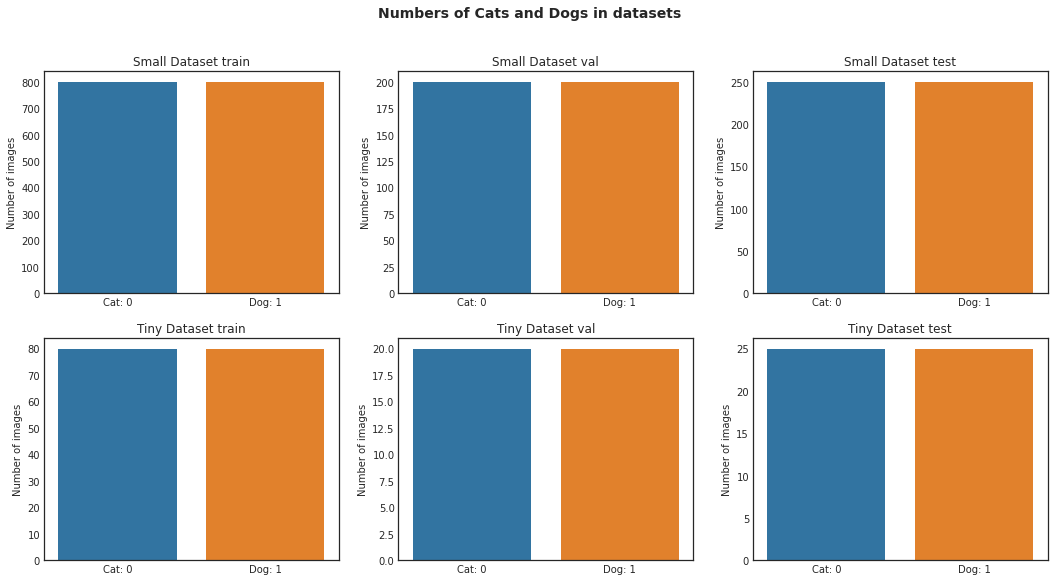

In [19]:
fig, axes = plt.subplots(2, 3, figsize=(18, 9))

for ax, dataset, name in zip(axes.flatten(), data, dataset_name):
    sns.countplot(x=dataset, ax=ax)
    ax.set(title=name, ylabel="Number of images")
    ax.set_xticklabels(["Cat: 0", "Dog: 1"], size=10)

fig.suptitle("Numbers of Cats and Dogs in datasets", size=14, fontweight="bold");

- skapa lämplig plot för att kontrollera att dataseten är slumpade (dvs inte ex [0, 0, ... 0, 1, 1, ..., 1]).

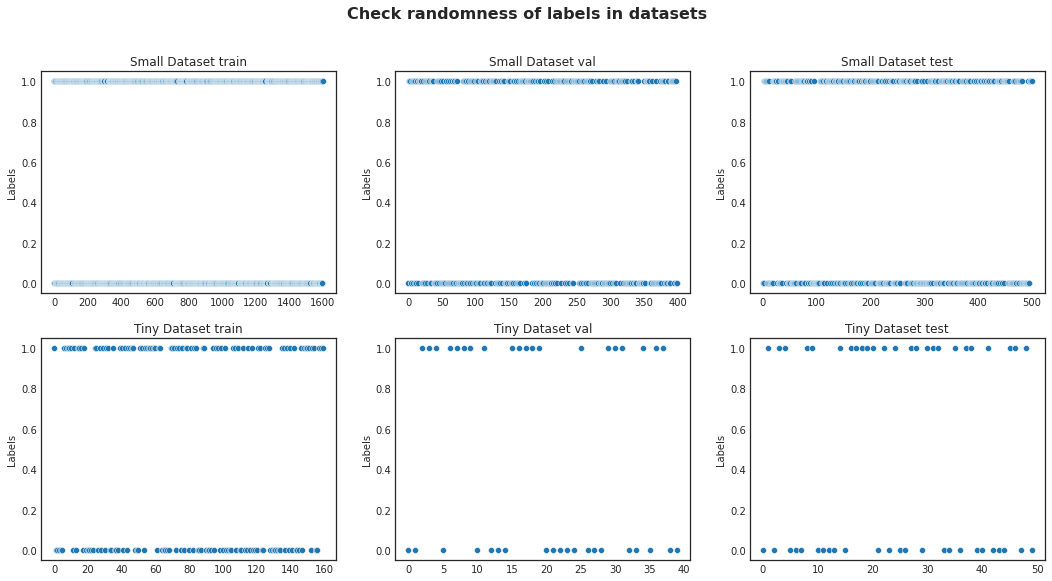

In [20]:
fig, axes = plt.subplots(2, 3, figsize=(18, 9))

for ax, dataset, name in zip(axes.flatten(), data, dataset_name):
    sns.scatterplot(data=dataset, ax=ax)
    ax.set(title=name, ylabel="Labels")
    ax.yticklabels=[0,1]

fig.suptitle("Check randomness of labels in datasets", size=16, fontweight="bold");

### 1. Bildbehandling (*)
Uppgifterna nedan ska upprepas för respektive experimentdataset om du också väljer att arbeta med
tinydatasetet.

- a) Skapa en plot för att visualisera bildstorlekarna i träningsdatan. Använd seaborns jointplot.

In [21]:
def plot_img_size(train_dir, train_name):
    heights = []
    widths = []
    imagefiles=[os.path.join(train_dir,f) for f in os.listdir(train_dir)]
    for image in imagefiles:
        img = plt.imread(image)
        #print(f"Original shape {img.shape}")
        height = img.shape[0]
        width = img.shape[1]
        heights.append(height)
        widths.append(width)

    figure = sns.jointplot(x=widths, y=heights)
    figure.ax_joint.set_xlabel('width')
    figure.ax_joint.set_ylabel('height')
    figure.fig.suptitle(f"Image size: {train_name}", size=12, fontweight='bold');

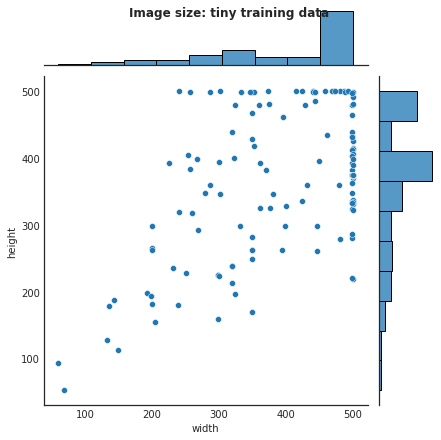

In [22]:
plot_img_size("experiment_tiny_data/train/", "tiny training data")

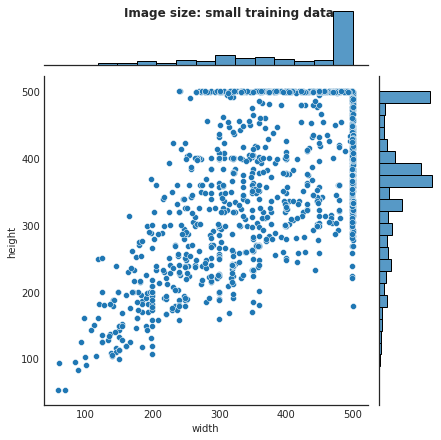

In [23]:
plot_img_size("experiment_small_data/train/", "small training data")

- b) Välj en lämplig bildstorlek att ändra samtliga bilder till. Gör en analys och fundera på om du behöver
slänga bilder. Hur kommer du fram till ditt val?

A rather small image size could of course shorten the running time, however it sacrifices the predicting accuracy because more inforamtion got lost.

I therefore want to make a balance between keep the quality of pictures and improve programming efficiency.

According to the [VERY DEEP CONVOLUTIONAL NETWORKS FOR LARGE-SCALE IMAGE RECOGNITION][link_paper]: 

[link_paper]: https://arxiv.org/pdf/1409.1556.pdf

I choose 224*224. In this paper, the input during training to VGG16 ConvNets is a fixed-size 224 × 224 RGB image.

In [24]:
IMG_SIZE = 224

- c) Gör resize sådant att samtliga bilder är samma storlek och spara dem i numpy arrays med följande
struktur:
Visualisera därefter ett par styckena bilder.

In [25]:
def resize_images(data):
    data_resized = [cv2.resize(data[i], (IMG_SIZE, IMG_SIZE)) for i in range(len(data))]
    data_resized = np.asarray(data_resized)
    return data_resized

In [26]:
X_train_small_resized = resize_images(X_train_small)
X_val_small_resized = resize_images(X_val_small)
X_test_small_resized = resize_images(X_test_small)
X_train_tiny_resized = resize_images(X_train_tiny)
X_val_tiny_resized = resize_images(X_val_tiny)
X_test_tiny_resized = resize_images(X_test_tiny)


In [27]:
print(X_train_small_resized.shape, X_val_small_resized.shape, X_test_small_resized.shape, X_train_tiny_resized.shape, X_val_tiny_resized.shape, X_test_tiny_resized.shape)

(1600, 224, 224, 3) (400, 224, 224, 3) (500, 224, 224, 3) (160, 224, 224, 3) (40, 224, 224, 3) (50, 224, 224, 3)


In [28]:
print(y_train_small.shape, y_val_small.shape, y_test_small.shape, y_train_tiny.shape, y_val_tiny.shape, y_test_tiny.shape)

(1600,) (400,) (500,) (160,) (40,) (50,)


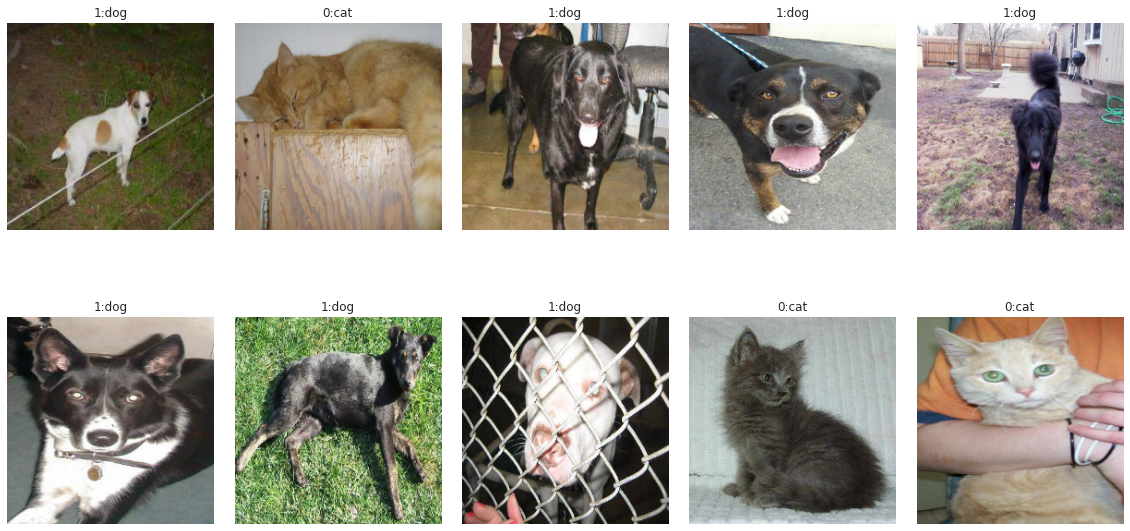

In [29]:
plot_imgs(X_train_small_resized, y_train_small)

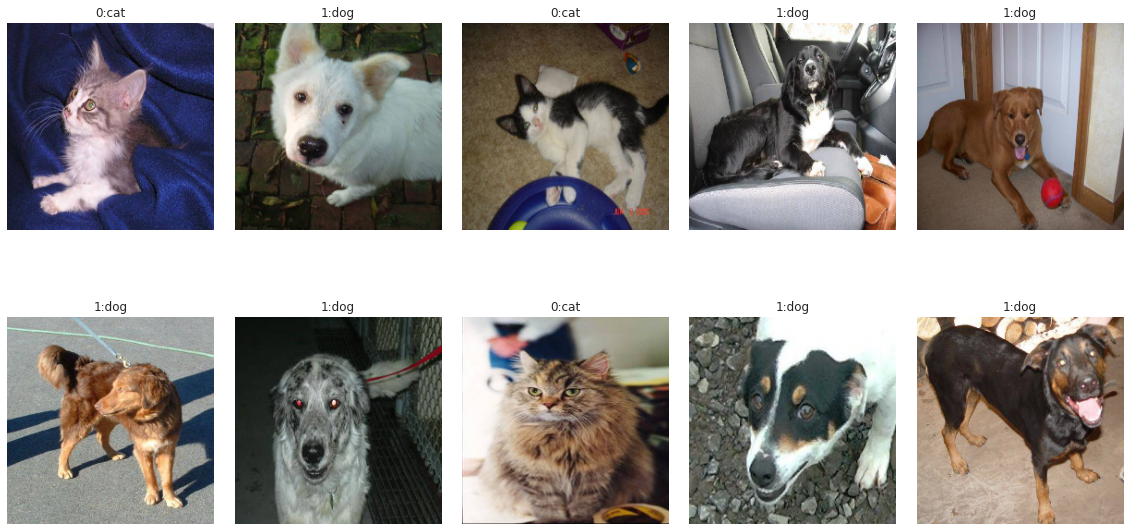

In [30]:
plot_imgs(X_test_small_resized, y_test_small)

d) Augmentera datan. Varför behövs dataaugmentering och hur beslutar vilka parametrar du valt för augmenteringen?


The movitation to use Data augmentation is to increase the amount of data. The techniques are: slightly modifing copies of already existing data, newly creating synthetic data from existing data etc. It acts as a regularizer. The benefit of data augmentation is to reduce overfitting prolem when training a machine learning model. 

In [31]:
print(f"min: {X_train_small_resized.min()}, max: {X_train_small_resized.max()}")
scaled_X_train_small_resized = X_train_small_resized.astype("float32") / 255
scaled_X_val_small_resized = X_val_small_resized.astype("float32") / 255
print(f"scaled min: {scaled_X_train_small_resized.min()}, scaled max: {scaled_X_train_small_resized.max()}")

min: 0, max: 255
scaled min: 0.0, scaled max: 1.0


In [32]:
print(f"min: {X_train_tiny_resized.min()}, max: {X_train_tiny_resized.max()}")
scaled_X_train_tiny_resized = X_train_tiny_resized.astype("float32") / 255
scaled_X_val_tiny_resized = X_val_tiny_resized.astype("float32") / 255
print(f"scaled min: {scaled_X_train_tiny_resized.min()}, scaled max: {scaled_X_train_tiny_resized.max()}")

min: 0, max: 255
scaled min: 0.0, scaled max: 1.0


In [33]:
scaled_X_train_small_resized.shape, scaled_X_val_small_resized.shape, y_train_small.shape, y_val_small.shape

((1600, 224, 224, 3), (400, 224, 224, 3), (1600,), (400,))

In [34]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def image_generator(scaled_X_train_resized, y_train, scaled_X_val_resized, y_val):
    train_image_generator = ImageDataGenerator(
        rotation_range=10,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        height_shift_range=0.2,
        width_shift_range=0.2,
    )

    # don't augment test data and validation data as we want to test on original data
    # we just instantiate an ImageDataGenerator without augmentation
    test_image_generator = ImageDataGenerator()


    # batch size 32 for mini-batch gradient descent 
    train_generator = train_image_generator.flow(
        scaled_X_train_resized, y_train, batch_size=32
    )
    # mini-batch gradient descent to get uncorrelated 
    # batch size 32 for mini-batch gradient descent 


    val_generator = test_image_generator.flow(scaled_X_val_resized, y_val, batch_size=32)

    # NumpyArrayIterator
    return train_generator, val_generator

In [35]:
train_generator_small, val_generator_small = image_generator(scaled_X_train_small_resized, y_train_small, scaled_X_val_small_resized, y_val_small)
train_generator_tiny, val_generator_tiny = image_generator(scaled_X_train_tiny_resized, y_train_tiny, scaled_X_val_tiny_resized, y_val_tiny)

### 2. Träna modeller (*)
För uppgifterna nedan, jobba med dataseten en åt gången:

small:
- utan augmentering
- med augmentering

tiny (BONUS):
- utan augmentering
- med augmentering

a) Använd följande nätverk och träna på datan. Gör hyperparametertuning för några parametrar (beskriv hur du gör). Visualisera och analysera loss-kurvor, accuracy-kurvor.

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam

def CNN_model(learning_rate=0.001, drop_rate=0.3, kernels=[32, 64, 128, 128]):
    adam = Adam(learning_rate=learning_rate)

    model = Sequential(name="CNN_model")

    for number_kernel in kernels:
        conv_layer = Conv2D(
            number_kernel,
            kernel_size=(3, 3),
            activation="relu",
            kernel_initializer="he_normal",
            input_shape=(IMG_SIZE, IMG_SIZE, 3),
        )

        model.add(conv_layer)
        # defaults to pool_size if None
        model.add(MaxPooling2D(pool_size=(2, 2), strides = (2,2)))

    model.add(Flatten())
    model.add(Dropout(drop_rate))
    model.add(Dense(512, activation="relu", kernel_initializer="he_normal"))
    model.add(Dense(1, activation="sigmoid"))

    model.compile(
        loss="binary_crossentropy", optimizer=adam, metrics=["acc"]
    )
 

    return model

model = CNN_model()

model.summary()

2022-05-13 21:16:06.755708: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Model: "CNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       14

2022-05-13 21:16:06.868971: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-13 21:16:06.869743: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-13 21:16:06.870842: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-13 21:16:06.871150: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

## Train on augmented data

 - steps_per_epoch is the number of times we generate our data from the generator
 - since we have batches on 32 samples for each time we generate, we could count how many samples before we cover original data size

### small sample

In [37]:
steps_per_epochs = len(scaled_X_train_small_resized)/32
validation_steps = int(len(scaled_X_val_small_resized)/32)

In [38]:
steps_per_epochs, validation_steps

(50.0, 12)

In [39]:
from tensorflow.keras.callbacks import EarlyStopping


early_stopper = EarlyStopping(
    monitor="val_acc", mode="max", patience=5, restore_best_weights=True
)

model.fit(
    train_generator_small,
    steps_per_epoch=steps_per_epochs,
    epochs=100,
    callbacks=[early_stopper],
    validation_data=val_generator_small,
    validation_steps=12,
)
 

2022-05-13 21:16:09.888176: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-05-13 21:16:11.713403: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


50/50 [==============================] - 23s 301ms/step - loss: 1.6760 - acc: 0.5169 - val_loss: 0.6914 - val_acc: 0.5026
Epoch 2/100
50/50 [==============================] - 15s 309ms/step - loss: 0.6932 - acc: 0.5394 - val_loss: 0.6999 - val_acc: 0.5000
Epoch 3/100
50/50 [==============================] - 15s 308ms/step - loss: 0.6963 - acc: 0.5088 - val_loss: 0.6935 - val_acc: 0.4896
Epoch 4/100
50/50 [==============================] - 16s 325ms/step - loss: 0.6934 - acc: 0.5106 - val_loss: 0.6940 - val_acc: 0.5000
Epoch 5/100
50/50 [==============================] - 15s 309ms/step - loss: 0.6945 - acc: 0.5088 - val_loss: 0.6930 - val_acc: 0.5000
Epoch 6/100
50/50 [==============================] - 16s 325ms/step - loss: 0.6922 - acc: 0.5225 - val_loss: 0.6909 - val_acc: 0.5234
Epoch 7/100
50/50 [==============================] - 15s 306ms/step - loss: 0.6931 - acc: 0.5350 - val_loss: 0.7000 - val_acc: 0.5286
Epoch 8/100
50/50 [==============================] - 16s 326ms/step - loss

In [40]:
metrics = pd.DataFrame(model.history.history)
metrics.head()

loss       acc  val_loss   val_acc
0  1.676008  0.516875  0.691407  0.502604
1  0.693175  0.539375  0.699874  0.500000
2  0.696271  0.508750  0.693500  0.489583
3  0.693379  0.510625  0.693980  0.500000
4  0.694529  0.508750  0.693015  0.500000

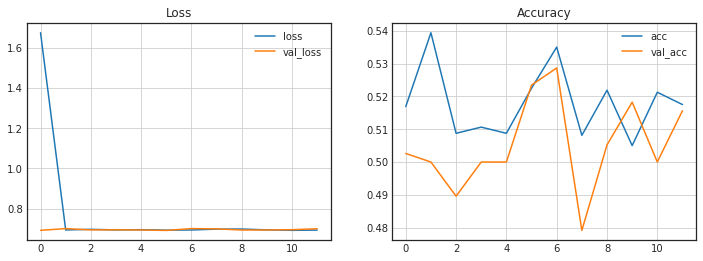

In [41]:
def plot_metrics(metrics):
    _, ax = plt.subplots(1,2, figsize = (12,4))
    metrics[["loss", "val_loss"]].plot(ax = ax[0], title = "Loss", grid = True)
    metrics[["acc", "val_acc"]].plot(ax = ax[1], title = "Accuracy", grid = True)

plot_metrics(metrics)

## without augmenatation: small dataset

In [42]:
model = CNN_model()
model.fit(
    scaled_X_train_small_resized, 
    y_train_small,
    steps_per_epoch=50,
    epochs=20,
    validation_data= (scaled_X_val_small_resized, y_val_small)
)

2022-05-13 21:19:36.478940: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 963379200 exceeds 10% of free system memory.
2022-05-13 21:19:37.428750: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 963379200 exceeds 10% of free system memory.


Epoch 1/20
50/50 [==============================] - 3s 47ms/step - loss: 1.1470 - acc: 0.5337 - val_loss: 0.6929 - val_acc: 0.5100
Epoch 2/20
50/50 [==============================] - 2s 33ms/step - loss: 0.6704 - acc: 0.5781 - val_loss: 0.6803 - val_acc: 0.5425
Epoch 3/20
50/50 [==============================] - 2s 33ms/step - loss: 0.6455 - acc: 0.6269 - val_loss: 0.6838 - val_acc: 0.6000
Epoch 4/20
50/50 [==============================] - 2s 34ms/step - loss: 0.6269 - acc: 0.6450 - val_loss: 0.6877 - val_acc: 0.5625
Epoch 5/20
50/50 [==============================] - 2s 33ms/step - loss: 0.5685 - acc: 0.7125 - val_loss: 0.6497 - val_acc: 0.6275
Epoch 6/20
50/50 [==============================] - 2s 33ms/step - loss: 0.5205 - acc: 0.7225 - val_loss: 0.6938 - val_acc: 0.6425
Epoch 7/20
50/50 [==============================] - 2s 33ms/step - loss: 0.4634 - acc: 0.7688 - val_loss: 0.7587 - val_acc: 0.6625
Epoch 8/20
50/50 [==============================] - 2s 33ms/step - loss: 0.3880 - a

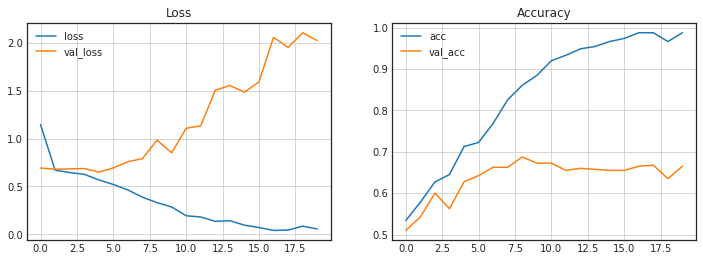

In [43]:
metrics = pd.DataFrame(model.history.history)
metrics.head()
plot_metrics(metrics)

## agumentation: tiny data

In [44]:
steps_per_epochs_tiny = len(scaled_X_train_tiny_resized)/32
validation_steps_tiny = int(len(scaled_X_val_tiny_resized)/32)

Epoch 1/100
5/5 [==============================] - 2s 365ms/step - loss: 9.5610 - acc: 0.4500 - val_loss: 0.8070 - val_acc: 0.5000
Epoch 2/100
5/5 [==============================] - 2s 372ms/step - loss: 0.7161 - acc: 0.4938 - val_loss: 0.6974 - val_acc: 0.4250
Epoch 3/100
5/5 [==============================] - 2s 336ms/step - loss: 0.6943 - acc: 0.4938 - val_loss: 0.6985 - val_acc: 0.4500
Epoch 4/100
5/5 [==============================] - 2s 310ms/step - loss: 0.6904 - acc: 0.5437 - val_loss: 0.7052 - val_acc: 0.5000
Epoch 5/100
5/5 [==============================] - 2s 313ms/step - loss: 0.6898 - acc: 0.5500 - val_loss: 0.7225 - val_acc: 0.4500
Epoch 6/100
5/5 [==============================] - 2s 317ms/step - loss: 0.7067 - acc: 0.5437 - val_loss: 0.7077 - val_acc: 0.4500


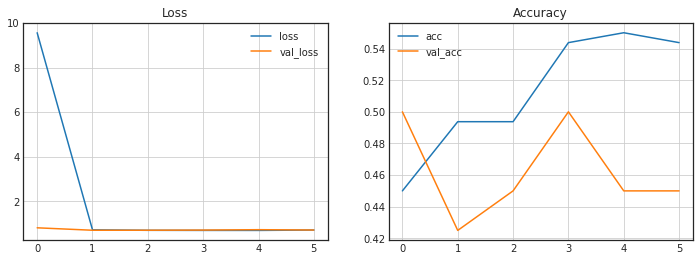

In [45]:
model = CNN_model()
model.fit(
    train_generator_tiny,
    #steps_per_epoch=steps_per_epochs_tiny,
    epochs=100,
    callbacks=[early_stopper],
    validation_data=val_generator_tiny,
    #validation_steps=validation_steps_tiny,
)
 
metrics = pd.DataFrame(model.history.history)
metrics.head()
plot_metrics(metrics)

## Without Augmentation: tiny data

Epoch 1/20
5/5 [==============================] - 1s 89ms/step - loss: 5.2359 - acc: 0.5437 - val_loss: 0.7424 - val_acc: 0.5000
Epoch 2/20
5/5 [==============================] - 0s 39ms/step - loss: 0.7539 - acc: 0.4938 - val_loss: 0.7187 - val_acc: 0.5000
Epoch 3/20
5/5 [==============================] - 0s 39ms/step - loss: 0.7015 - acc: 0.4875 - val_loss: 0.6953 - val_acc: 0.5000
Epoch 4/20
5/5 [==============================] - 0s 39ms/step - loss: 0.6980 - acc: 0.5875 - val_loss: 0.6972 - val_acc: 0.5000
Epoch 5/20
5/5 [==============================] - 0s 39ms/step - loss: 0.6752 - acc: 0.5938 - val_loss: 0.6800 - val_acc: 0.5250
Epoch 6/20
5/5 [==============================] - 0s 39ms/step - loss: 0.6262 - acc: 0.6625 - val_loss: 0.6914 - val_acc: 0.5500
Epoch 7/20
5/5 [==============================] - 0s 39ms/step - loss: 0.5563 - acc: 0.6875 - val_loss: 0.8416 - val_acc: 0.5250
Epoch 8/20
5/5 [==============================] - 0s 39ms/step - loss: 0.5459 - acc: 0.7125 - val

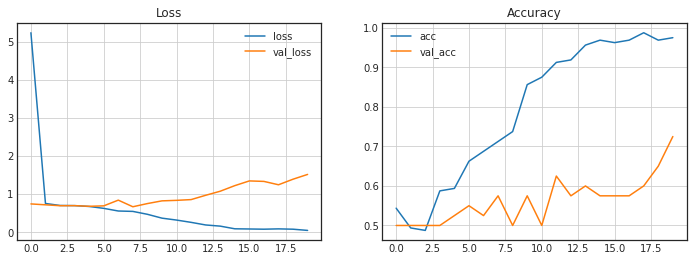

In [46]:
model = CNN_model()
model.fit(
    scaled_X_train_tiny_resized, 
    y_train_tiny,
    #steps_per_epoch=steps_per_epochs_tiny,
    epochs=20,
    validation_data= (scaled_X_val_tiny_resized, y_val_tiny)
    #validation_steps = validation_steps_tiny
)
 
metrics = pd.DataFrame(model.history.history)
metrics.head()
plot_metrics(metrics)

b) Förändra nätverket i a) experimentera och ändra i lite komponenter. Beskriv vad du ändrar och varför.
Glöm inte att evaluera på valideringsdatan.

## Hyperparameter tuning 
We can tune several parameters, e.g.
- dropout rate
- learning rate
- different network configurations

For improve running spead, I only tune dropout rate here

In [47]:
def evaluate_model(**kwargs):
    model = CNN_model(**kwargs)
    model.fit(
        train_generator_small,
        validation_data=val_generator_small,
        epochs=100,  # small epochs to make training faster
        steps_per_epoch=steps_per_epochs,
        callbacks=[early_stopper],
        validation_steps=12,
    )
    metrics = pd.DataFrame(model.history.history)

    val_acc = metrics["val_acc"].iloc[-1]
    return val_acc

In [48]:
dropout_accuracies = {}
for drop_rate in np.arange(.1, .6, .1):
    # because of floating point precision
    drop_rate = np.round(drop_rate,1) 
    dropout_accuracies[drop_rate] = evaluate_model(drop_rate = drop_rate)

Epoch 1/100
50/50 [==============================] - 17s 322ms/step - loss: 1.0997 - acc: 0.5094 - val_loss: 0.6937 - val_acc: 0.4922
Epoch 2/100
50/50 [==============================] - 15s 307ms/step - loss: 0.6931 - acc: 0.5331 - val_loss: 0.6939 - val_acc: 0.5078
Epoch 3/100
50/50 [==============================] - 16s 323ms/step - loss: 0.6956 - acc: 0.5081 - val_loss: 0.6952 - val_acc: 0.4714
Epoch 4/100
50/50 [==============================] - 15s 305ms/step - loss: 0.6936 - acc: 0.5175 - val_loss: 0.6922 - val_acc: 0.5182
Epoch 5/100
50/50 [==============================] - 16s 326ms/step - loss: 0.6901 - acc: 0.5569 - val_loss: 0.7082 - val_acc: 0.5130
Epoch 6/100
50/50 [==============================] - 15s 305ms/step - loss: 0.6881 - acc: 0.5406 - val_loss: 0.6961 - val_acc: 0.5026
Epoch 7/100
50/50 [==============================] - 16s 327ms/step - loss: 0.6891 - acc: 0.5387 - val_loss: 0.6902 - val_acc: 0.5599
Epoch 8/100
50/50 [==============================] - 15s 309ms

<AxesSubplot:title={'center':'Tuning dropouts'}, xlabel='Dropouts', ylabel='Validation accuracy'>

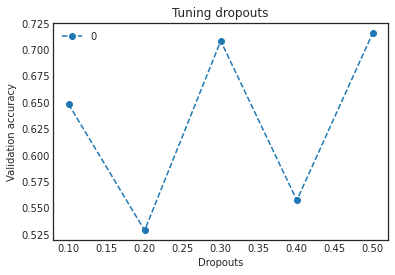

In [49]:
pd.DataFrame(dropout_accuracies.values(), index=dropout_accuracies.keys()).plot(
    title="Tuning dropouts", xlabel="Dropouts", ylabel="Validation accuracy", style = "--o"
)


The highest validation accurary is when dropout rate is equal to 0.5. I therefore choose 0.5.

---
## Train and evaluate on chosen model

In [50]:
# Concatenate training and validation data
X_train_full = np.concatenate((scaled_X_train_small_resized, scaled_X_val_small_resized))
y_train_full = np.concatenate((y_train_small, y_val_small))
X_train_full.shape, y_train_full.shape

((2000, 224, 224, 3), (2000,))

In [52]:
model = CNN_model(drop_rate=0.5)
model.fit(
    X_train_full,
    y_train_full,
    epochs=100,
    callbacks=[early_stopper],
)




2022-05-13 21:58:04.689289: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1204224000 exceeds 10% of free system memory.


Epoch 1/100
63/63 [==============================] - 3s 30ms/step - loss: 0.8853 - acc: 0.5180
Epoch 2/100
63/63 [==============================] - 2s 30ms/step - loss: 0.6784 - acc: 0.5590
Epoch 3/100
63/63 [==============================] - 2s 30ms/step - loss: 0.6561 - acc: 0.6160
Epoch 4/100
63/63 [==============================] - 2s 31ms/step - loss: 0.6229 - acc: 0.6660
Epoch 5/100
63/63 [==============================] - 2s 30ms/step - loss: 0.5922 - acc: 0.6775
Epoch 6/100
63/63 [==============================] - 2s 30ms/step - loss: 0.5569 - acc: 0.7265
Epoch 7/100
63/63 [==============================] - 2s 29ms/step - loss: 0.4991 - acc: 0.7635
Epoch 8/100
63/63 [==============================] - 2s 30ms/step - loss: 0.4377 - acc: 0.7875
Epoch 9/100
63/63 [==============================] - 2s 30ms/step - loss: 0.3820 - acc: 0.8235
Epoch 10/100
63/63 [==============================] - 2s 31ms/step - loss: 0.3035 - acc: 0.8670
Epoch 11/100
63/63 [=============================

In [59]:
y_test_small

array([0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0,

              precision    recall  f1-score   support

           0       0.75      0.63      0.69       250
           1       0.68      0.80      0.73       250

    accuracy                           0.71       500
   macro avg       0.72      0.71      0.71       500
weighted avg       0.72      0.71      0.71       500



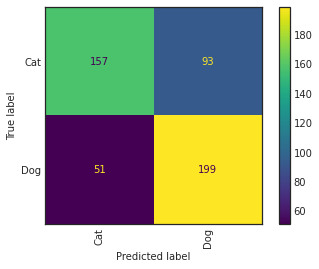

In [68]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

y_pred = model.predict(X_test_small_resized)
y_pred = (y_pred > .5)*1
print(classification_report(y_test_small, y_pred))

cm = confusion_matrix(y_test_small, y_pred)
ConfusionMatrixDisplay(cm, display_labels=["Cat", "Dog"]).plot()
plt.xticks(rotation = 90);

The weight avrage prediction precision rate is 0.72, which is ok. Of course, if time allowed, I could tune more parameters in future works.

d) Tag ett eller flera av nätverken (VGG16, Resnet, Xception, Inception), läs deras forskningsartikel,
sammanfatta kort ca 1/2 - 1 sida för en artikel. Utför därefter transfer learning och evaluera din modell.
Beskriv också hur transfer learning fungerar.
Number of epochs with no improvement after which training will be stopped.

**VGG16**

 
VGG16 is a convolution neural net (CNN ) architecture. It was published in 2014 which was used to win ILSVR(Imagenet) competition in 2014. It is considered to be one of the excellent and simplist (among the other cnn architectures used in Imagenet competition) vision model architecture. It's Key Characteristics are:

It has 16 layers that have weights and bias parameters are learnt. Of these 16 layers, 13 convolutional layers are stacked one after the other and 3 dense layers are for classification

The number of filters in the convolution layers follow an increasing pattern.

The informative features got from max pooling layers at different steps in the VGG16 architecture.

The dense layers comprises of 4096, 4096, and 1000 nodes each.

However, it is slow to train and produces the model with very large size.

It does not have a large number of hyper-parameter

They focused on having convolution layers of 3x3 filter with a stride 1 and always used same padding and maxpool layer of 2x2 filter of stride.

In the end it has 2 FC(fully connected layers) followed by a softmax for output. 

This network is a pretty large network and it has about 138 million (approx) parameters.

The implication of vgg16 is able to through PreTrained Model from keras libaray. One can load the saved model weights, frozen some features and use them for different purposes : which is called transfer learning. 




In [131]:
from keras.models import Sequential
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from tensorflow.keras.applications import VGG16
from keras.models import Model

image_size = 224
input_shape = (image_size, image_size, 3)

epochs = 5
batch_size = 16

pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")
    
for layer in pre_trained_model.layers[:15]:
    layer.trainable = False

for layer in pre_trained_model.layers[15:]:
    layer.trainable = True
    
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
    
# Flatten the output layer to 1 dimension
x = GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)

model.compile(loss='binary_crossentropy',
              optimizer= "adam",
              metrics=['accuracy'])

model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [132]:
# fine-tune the model
history = model.fit_generator(
    train_generator_small,
    epochs=100,
    validation_data=val_generator_small,
    callbacks=[early_stopper],
    validation_steps=12,
    steps_per_epoch=steps_per_epochs)


Epoch 1/100
50/50 [==============================] - 18s 338ms/step - loss: 0.8835 - accuracy: 0.4831 - val_loss: 0.6931 - val_accuracy: 0.5052
Epoch 2/100
50/50 [==============================] - 18s 351ms/step - loss: 0.6932 - accuracy: 0.4875 - val_loss: 0.6931 - val_accuracy: 0.4974
Epoch 3/100
50/50 [==============================] - 17s 339ms/step - loss: 0.6933 - accuracy: 0.4925 - val_loss: 0.6931 - val_accuracy: 0.5104
Epoch 4/100
50/50 [==============================] - 17s 343ms/step - loss: 0.6932 - accuracy: 0.4913 - val_loss: 0.6930 - val_accuracy: 0.5104
Epoch 5/100
50/50 [==============================] - 18s 351ms/step - loss: 0.6932 - accuracy: 0.5050 - val_loss: 0.6932 - val_accuracy: 0.4974
Epoch 6/100
50/50 [==============================] - 17s 335ms/step - loss: 0.6933 - accuracy: 0.4875 - val_loss: 0.6931 - val_accuracy: 0.5026
Epoch 7/100
50/50 [==============================] - 18s 352ms/step - loss: 0.6934 - accuracy: 0.4831 - val_loss: 0.6931 - val_accuracy:

In [133]:
metrics = pd.DataFrame(history.history)
metrics.head()

loss  accuracy  val_loss  val_accuracy
0  0.883482  0.483125  0.693135      0.505208
1  0.693218  0.487500  0.693150      0.497396
2  0.693258  0.492500  0.693087      0.510417
3  0.693241  0.491250  0.693033      0.510417
4  0.693193  0.505000  0.693157      0.497396

<AxesSubplot:>

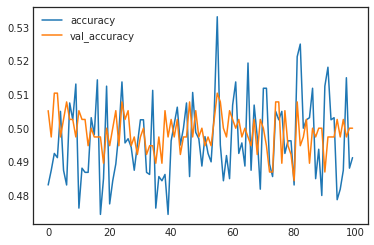

In [135]:
metrics[["accuracy", "val_accuracy"]].plot()

<AxesSubplot:>

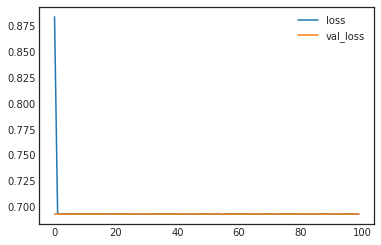

In [136]:
metrics[["loss", "val_loss"]].plot()

References:
1. https://www.kaggle.com/code/bulentsiyah/dogs-vs-cats-classification-vgg16-fine-tuning
2. https://arxiv.org/pdf/1409.1556.pdf
3. https://www.kaggle.com/code/shivamb/cnn-architectures-vgg-resnet-inception-tl
4. https://towardsdatascience.com/step-by-step-vgg16-implementation-in-keras-for-beginners-a833c686ae6c
5. 